In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
#Carico R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
#Carico tutti i pacchetti necessari
%%capture
%%R
if (!require("ggplot2"))    install.packages('ggplot2')
if (!require("forecast"))   install.packages('forecast')
if (!require("tidyverse"))  install.packages('tidyverse')
if (!require("KFAS"))       install.packages('KFAS')
if (!require("data.table")) install.packages('data.table')
if (!require("timeDate"))   install.packages('timeDate')
if (!require("xts"))        install.packages('xts')

library("ggplot2")
library("forecast")
library("tidyverse")
library("KFAS")

In [51]:
#Carico il dataset
%%R 
#path <- "/content/drive/My Drive/time_series/"
df <- read.csv2(paste0("time_series_dataset.csv"), dec = ".")
df$Data <- as.Date(df$Data)

print(head(df))

        Data     value
1 2010-01-01  41.65104
2 2010-01-02 131.28660
3 2010-01-03 117.38812
4 2010-01-04 116.46128
5 2010-01-05 123.82376
6 2010-01-06 104.28556


In [52]:
#Eseguiamo lo split in train e validation secondo una proporzione 83-27
%%R

df_ts <- xts(df$value, start=c(2010,1), order.by=df$Data)

train <- df_ts['2010-01-01/2017-06-30']
validation <- df_ts['2017-07-01/2018-12-31']

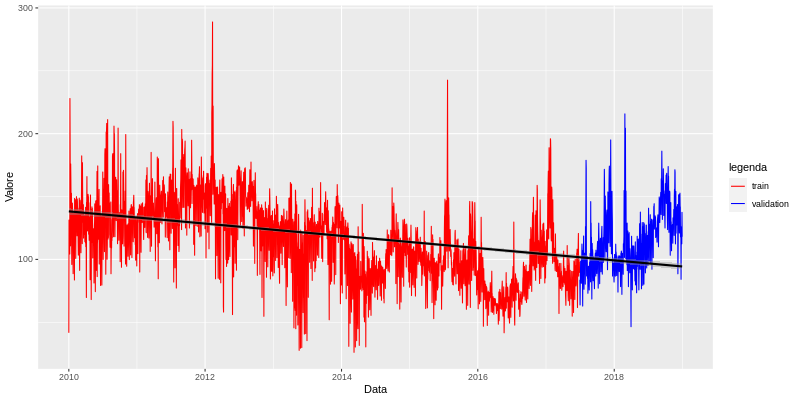

In [53]:
%%R -w 800 -h 400

rbind(data.frame(Data=index(train), Valore=coredata(train), legenda="train"),
     data.frame(Data=index(validation), Valore=coredata(validation), legenda="validation")) %>%
    ggplot(aes(x=Data, y=Valore)) +
        geom_line(aes(colour = legenda))  +
        scale_color_manual(values=c('red','blue')) +
        stat_smooth(method = "lm", se = T, col="black", level=0.99)

Già dalla rappresentazione, sembra esserci un leggero trend.

<hr />

<h1> 1) ARIMA </h1>

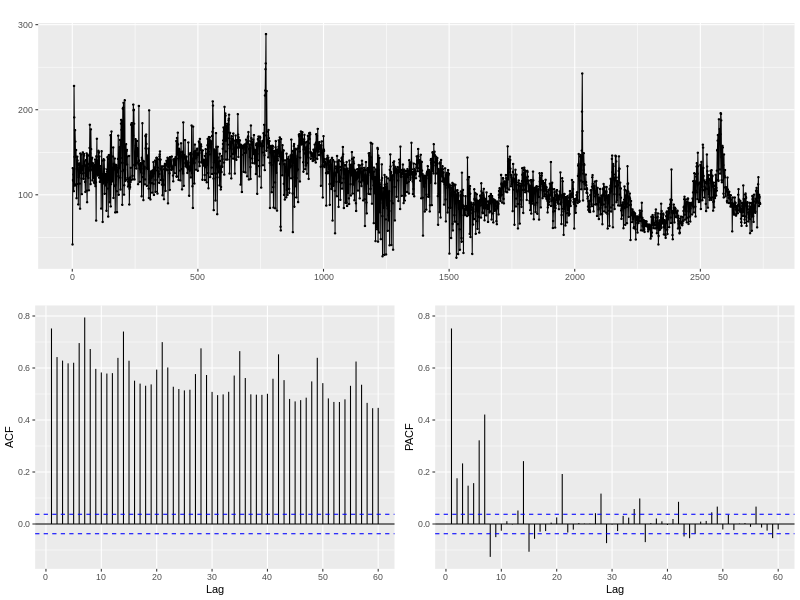

In [ ]:
%%R -w 800 -h 600
ggtsdisplay(train, lag.max= 60)

Osservando i correlogrammi, è possibile notare immediatamente alcune cose:
<ol>
<li>C'è una stagionalità settimanale che, a prima vista, sembra presentare sia una componente SAR, proabilmente un SAR(1) che una componente SMA, che sembrerebbe essere un SMA(1). Dato il lieve trend che la serie sembra presentare, potrebbe rendersi necessaria un'integrazione stagionale per annullare l'effetto combinato di trend-stagionalità.</li>
<p></p>
<li>Dati i primi 6 picchi iniziali piuttosto alti presenti sia nella PACF che nella ACF, ci si aspettano 2 componenti AR(x) e MA(x) di grado compreso tra 1 e 6. 
</ol>



Iniziamo con l'individuazione della componente stagionale.

Series: train 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
        sar1     sma1      mean
      0.9598  -0.5488  104.4242
s.e.  0.0065   0.0238    3.1736

sigma^2 estimated as 245:  log likelihood=-11419.73
AIC=22847.46   AICc=22847.48   BIC=22871.12


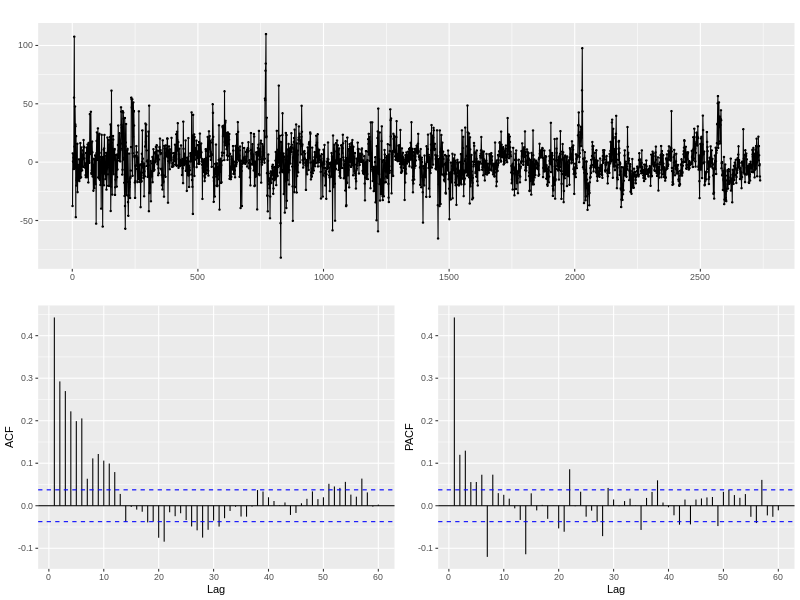

In [ ]:
%%R -w 800 -h 600
modello0 <- Arima(train, c(0,0,0), list(order=c(1,0,1), period=7), lambda = 'auto')
ggtsdisplay(modello0$residuals, lag.max= 60)
modello0

In [ ]:
%%R
accuracy(modello0)

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.1256231 17.71104 12.70845 -2.727137 11.80893 0.8367193
                  ACF1
Training set 0.4438411


Vediamo che il coefficiente SAR è molto vicino a 1, il che indica la presenza di una radice (quasi) unitaria. Proviamo ad integrare.

Series: train 
ARIMA(0,0,0)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
        sar1     sma1
      0.2877  -0.8041
s.e.  0.0316   0.0214

sigma^2 estimated as 242.8:  log likelihood=-11375.7
AIC=22757.4   AICc=22757.41   BIC=22775.14


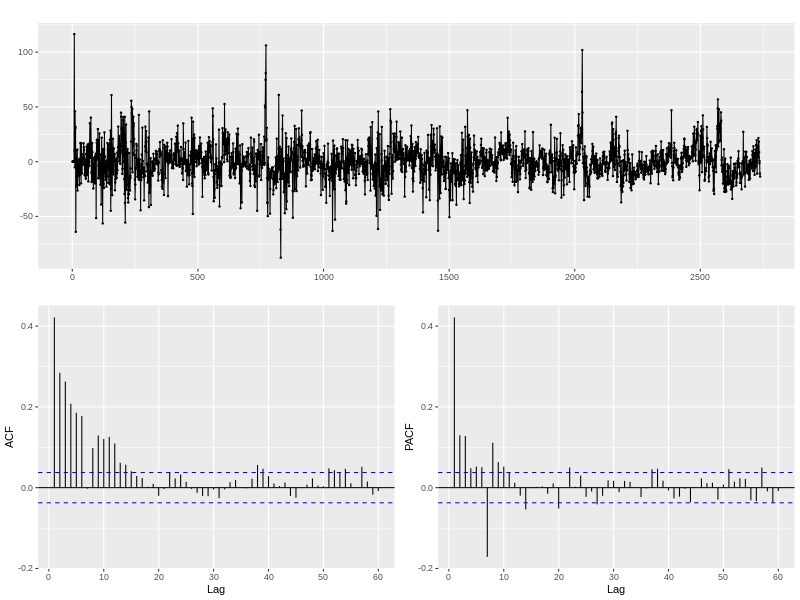

In [ ]:
%%R -w 800 -h 600
modello1 <- Arima(train, c(0,0,0), list(order=c(1,1,1), period=7), lambda = 'auto')
ggtsdisplay(modello1$residuals, lag.max= 60)
modello1

In [ ]:
%%R
accuracy(modello1)

                    ME     RMSE      MAE       MPE     MAPE     MASE     ACF1
Training set -0.333987 17.60693 12.63468 -2.500528 11.72467 0.831862 0.422229


Dopo aver risolto la componente stagionale, analizzando i residui vediamo che ci sono ancora dei lag che superano ampiamente la banda, in particolare fino al 12esimo lag nella ACF e fino all'ottavo lag nella PACF.  Prendendo come misure di riferimento il <b>RMSE</b>, proviamo ad eseguire un <i>grid search</i> per trovare la combinazione migliore fra questi due valori.

In [ ]:
%%time
%%R

modello_arima <- Arima(train, c(0,0,0), list(order=c(1,1,2), period=7), 
                  lambda = "auto")
rmse_migliore <-accuracy(modello_arima)[2]

for (i in 0:8){
    for (j in 0:12){
        tryCatch({
            modello <- Arima(train, c(i,0,j), list(order=c(1,1,2), period=7), 
                          lambda = "auto")
            rmse_modello <- accuracy(modello)[2]
            if (rmse_modello < rmse_migliore){
                modello_arima <- modello
                rmse_migliore <- rmse_modello
            }
        }, error=function(e){rmse_modello <- 99999})
        print(paste0("AR-",i," MA-",j,
                     " -- RMSE:",rmse_modello, " --RMSE MIGLIORE:",rmse_migliore), 
              flush=TRUE)
    }
}

[1] "AR-0 MA-0 -- RMSE:17.5330290090029 --RMSE MIGLIORE:17.5330290090029"
[1] "AR-0 MA-1 -- RMSE:16.0631955508253 --RMSE MIGLIORE:16.0631955508253"
[1] "AR-0 MA-2 -- RMSE:15.7599262856659 --RMSE MIGLIORE:15.7599262856659"
[1] "AR-0 MA-3 -- RMSE:15.5011958444917 --RMSE MIGLIORE:15.5011958444917"
[1] "AR-0 MA-4 -- RMSE:15.3592757975377 --RMSE MIGLIORE:15.3592757975377"
[1] "AR-0 MA-5 -- RMSE:15.3107978449454 --RMSE MIGLIORE:15.3107978449454"
[1] "AR-0 MA-6 -- RMSE:14.9474271629977 --RMSE MIGLIORE:14.9474271629977"
[1] "AR-0 MA-7 -- RMSE:14.7557977932343 --RMSE MIGLIORE:14.7557977932343"
[1] "AR-0 MA-8 -- RMSE:14.6950349857857 --RMSE MIGLIORE:14.6950349857857"
[1] "AR-0 MA-9 -- RMSE:14.6950148534057 --RMSE MIGLIORE:14.6950148534057"
[1] "AR-0 MA-10 -- RMSE:14.6947789298588 --RMSE MIGLIORE:14.6947789298588"
[1] "AR-0 MA-11 -- RMSE:14.6941463428681 --RMSE MIGLIORE:14.6941463428681"
[1] "AR-0 MA-12 -- RMSE:14.6629335767821 --RMSE MIGLIORE:14.6629335767821"
[1] "AR-1 MA-0 -- RMSE:15.422247982

<br />
Il modello con RMSE minore ha AR(6) e MA(12).
<br />

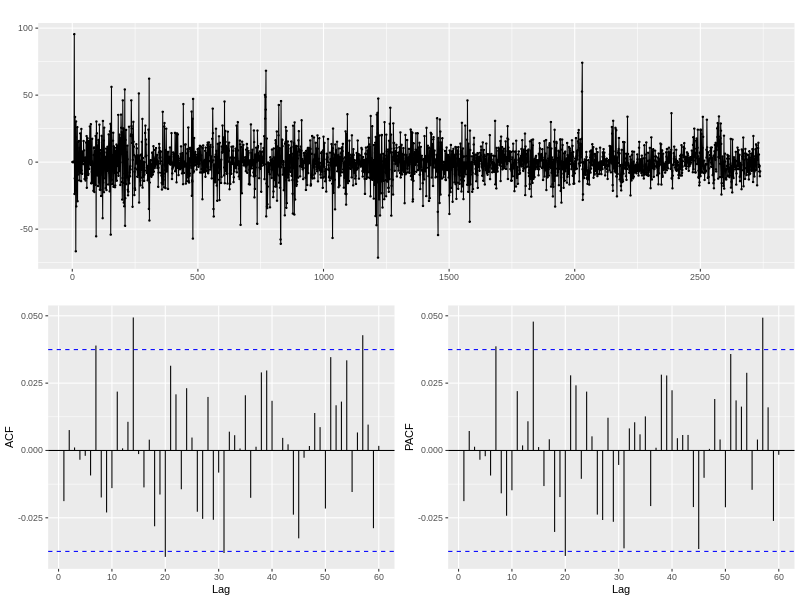

In [ ]:
%%R -w 800 -h 600
ggtsdisplay(modello_arima$residuals, lag.max= 60)

In [ ]:
%%R
accuracy(modello_arima)

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.1837103 14.62172 10.31776 -1.916413 9.702123 0.6793171
                   ACF1
Training set -0.0181509


Ricordando il leggero trend notato all'inizio, proviamo ad aggiungere un'integrazione.

Series: train 
ARIMA(6,1,12)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
          ar1     ar2     ar3      ar4      ar5     ar6      ma1      ma2
      -0.5778  0.0978  0.4339  -0.2176  -0.0752  0.0228  -0.0236  -0.6292
s.e.      NaN     NaN     NaN      NaN      NaN     NaN      NaN      NaN
          ma3     ma4      ma5      ma6      ma7      ma8     ma9    ma10
      -0.4766  0.4785  -0.0144  -0.0593  -0.5477  -0.0114  0.3065  0.2888
s.e.      NaN     NaN      NaN   0.0369      NaN      NaN     NaN     NaN
         ma11    ma12   sar1     sma1
      -0.2763  -6e-04  0.666  -0.9803
s.e.      NaN     NaN    NaN   0.0038

sigma^2 estimated as 169.3:  log likelihood=-10880.26
AIC=21802.52   AICc=21802.86   BIC=21926.67


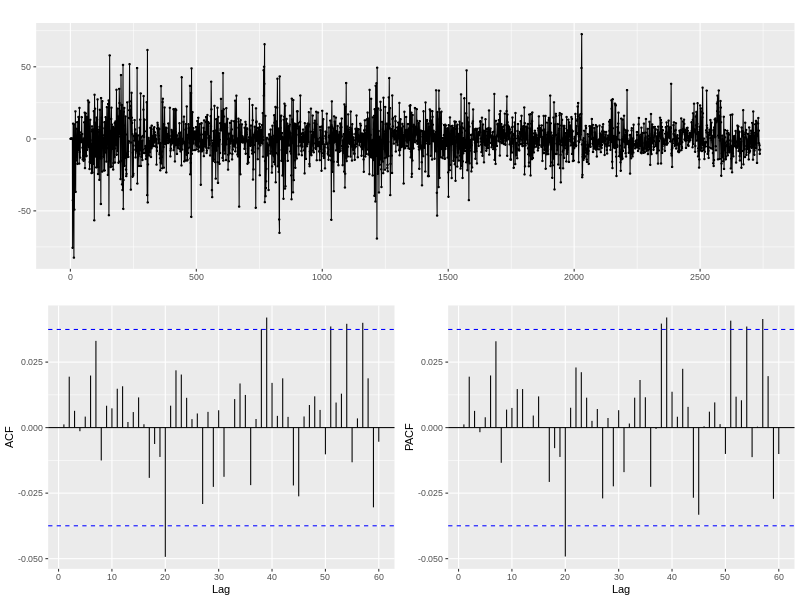

In [ ]:
%%R -w 800 -h 600
modello_arima_2 <- Arima(train, c(6,1,12), list(order=c(1,1,1), period=7), lambda = 'auto')
ggtsdisplay(modello_arima_2$residuals, lag.max= 60)
modello_arima_2

In [ ]:
%%R
accuracy(modello_arima_2)

                     ME     RMSE     MAE       MPE     MAPE      MASE
Training set -0.2934778 14.64848 10.3438 -1.849052 9.715097 0.6810313
                   ACF1
Training set 0.00208349


Vediamo che l'integrazione non migliora l'RMSE, quindi il modello migliore rimane il precedente. Osserando i residui di tale modello, si può notare che quasi tutti i lag rientrano nella banda, ad eccezione di due picchi in posizione 14 e 56, sia nella ACF che nella PACF.
<p></p>
 

Series: train 
ARIMA(6,0,12)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6     ma1     ma2     ma3
      0.1392  0.1184  0.1381  0.1585  0.1414  0.0666  0.2546  0.0406  0.0084
s.e.  1.0805  0.2874  0.2811  0.4772  0.2082  0.0698  1.0809  0.3855  0.2018
          ma4      ma5     ma6      ma7      ma8      ma9    ma10    ma11
      -0.0720  -0.1157  0.0084  -0.9691  -0.2436  -0.0330  0.0074  0.0914
s.e.   0.3298   0.2025  0.0337   0.0194   1.0472   0.3716  0.1971  0.3434
        ma12    sar1     sma1
      0.1381  0.6328  -0.5171
s.e.  0.2184  0.2701   0.3510

sigma^2 estimated as 168.5:  log likelihood=-10876.36
AIC=21794.71   AICc=21795.05   BIC=21918.87


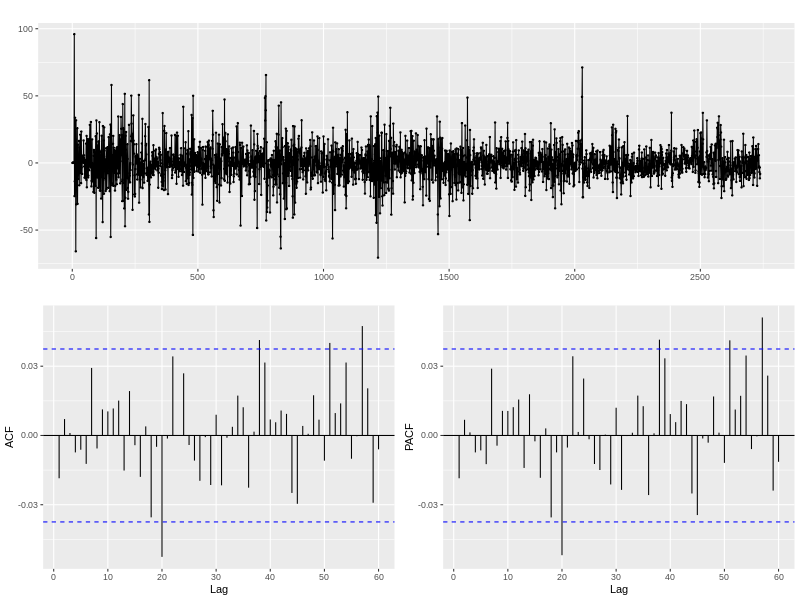

In [42]:
%%R -w 800 -h 600
modello_migliore <- Arima(train, c(6,0,12), list(order=c(1,1,1), period=7), lambda = 'auto')
ggtsdisplay(modello_migliore$residuals, lag.max= 60)
modello_migliore

In [ ]:
%%R
accuracy(modello_migliore)

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.1023005 14.61215 10.30203 -1.796518 9.656427 0.6782815
                    ACF1
Training set -0.01795256


In [54]:
%%R
#creaiamo una funzione per cambiare formato dei dati da xts a ts
xts_ts <- function(x, start="2010-01-01"){
    n <- length(x)
    ind <- as.numeric(index(x) - as.Date(start))
    tsx <- ts(x, start=ind[1]+1, end=ind[n]+1, frequency=frequency(x))
    tsx
}


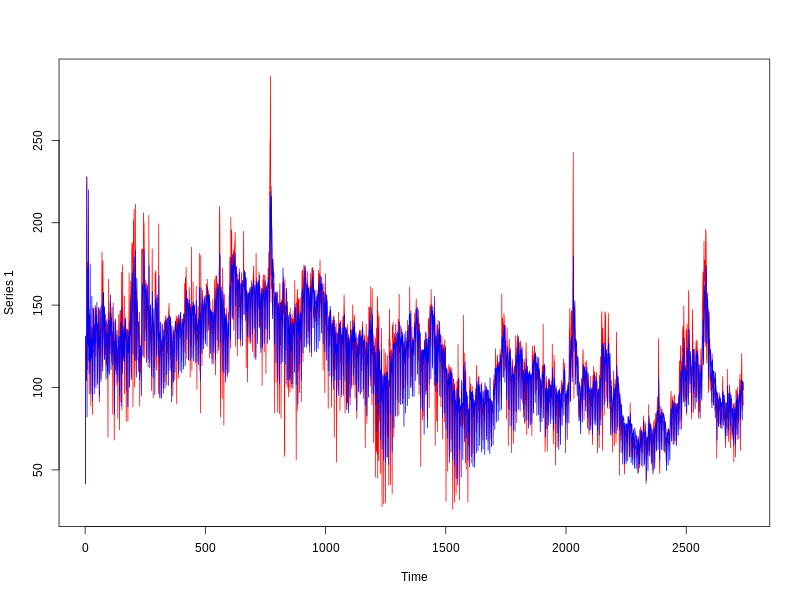

In [ ]:
%%R -w 800 -h 600

plot(xts_ts(train),col="red", series = "Reale")
lines(modello_migliore$fitted,col="blue", series = "Simulata")

Vediamo come si comporta il modello appena trovato sul validation set.

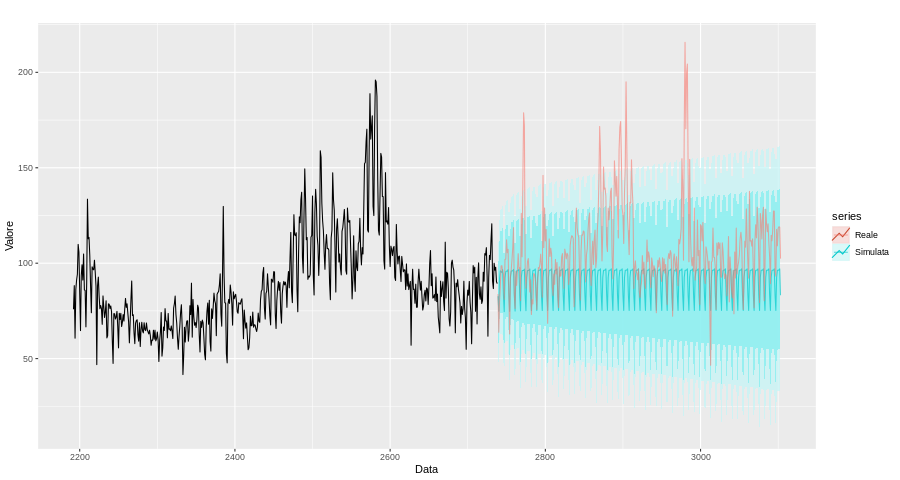

In [43]:
%%R -w 900

previsione1 <- forecast(modello_migliore, h=365)

autoplot(xts_ts(df_ts["2016-01-01/2017-06-30"])) +
autolayer(previsione1,series="Simulata", alpha=0.7) +
autolayer(xts_ts(validation["2017-07-01/2018-06-30"]), series="Reale", alpha=0.6) +
xlab("Data") +
ylab("Valore")

In [ ]:
%%R
score0 <- c(mean(abs(previsione1$mean - validation[1:334])/validation[1:334]))
print(paste0("MAPE sul validation: ", score0))

[1] "MAPE sul validation: 0.144273404201024"


Notiamo che il modello attuale restituisce valori troppo poco variabili e non riesce a cogliere quella che sembra una multi-stagionalità. 
<br><br>
Proviamo ad individuarla osservando l'andamento dei residui per un periodo di tempo superiore.



Series: train 
ARIMA(6,0,12)(1,1,1)[7] 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6     ma1     ma2     ma3
      0.1392  0.1184  0.1381  0.1585  0.1414  0.0666  0.2546  0.0406  0.0084
s.e.  1.0805  0.2874  0.2811  0.4772  0.2082  0.0698  1.0809  0.3855  0.2018
          ma4      ma5     ma6      ma7      ma8      ma9    ma10    ma11
      -0.0720  -0.1157  0.0084  -0.9691  -0.2436  -0.0330  0.0074  0.0914
s.e.   0.3298   0.2025  0.0337   0.0194   1.0472   0.3716  0.1971  0.3434
        ma12    sar1     sma1
      0.1381  0.6328  -0.5171
s.e.  0.2184  0.2701   0.3510

sigma^2 estimated as 168.5:  log likelihood=-10876.36
AIC=21794.71   AICc=21795.05   BIC=21918.87


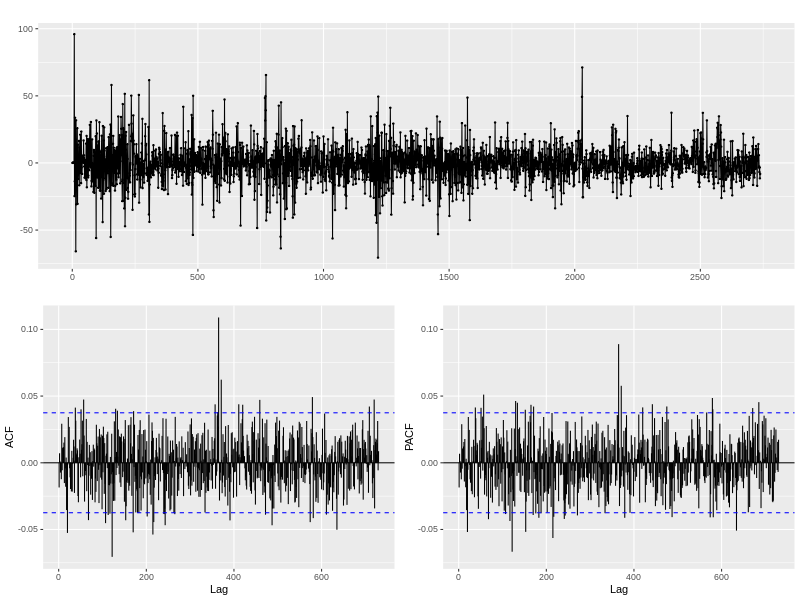

In [ ]:
%%R -w 800 -h 600
ggtsdisplay(modello_migliore$residuals, lag.max= 730)
modello_migliore

Osservando i picchi che superano la banda, sembrerebbe esserci una componente stagionale all'incirca annuale. Proviamo ad inserirla nel modello aggiungendo dei regressori trigonometrici esterni, con frequenza pari a 365.

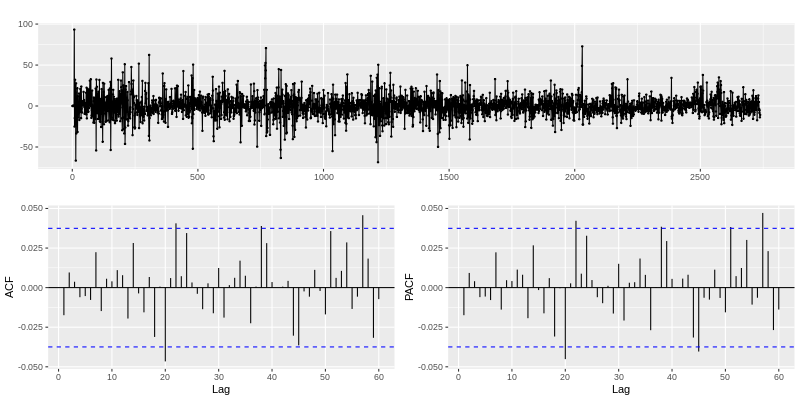

CPU times: user 6min 6s, sys: 4min 27s, total: 10min 33s
Wall time: 5min 29s


In [44]:
%%time
%%R -w 800 -h 400

freq <- outer(1:nrow(df), 1:12)*2*pi/365 

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:12)
si   <- sin(freq)                   
colnames(si) <- paste("sin", 1:12)

cs_si <- as.matrix(cbind(cs,si))

xreg <- cs_si 

mod1_reg <- Arima(train, c(6,0,12), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], 
              include.constant = TRUE, 
              lambda = "auto")

ggtsdisplay(mod1_reg$residuals, lag.max = 60)

Series: train 
Regression with ARIMA(6,0,12)(1,1,1)[7] errors 
Box Cox transformation: lambda= 0.9742241 

Coefficients:
         ar1      ar2     ar3     ar4     ar5     ar6      ma1     ma2     ma3
      0.5018  -0.0125  0.0968  0.1096  0.0394  0.0796  -0.1339  0.0059  0.0010
s.e.  0.4532   0.4088  0.2890  0.3303  0.3528  0.0893   0.4541  0.3037  0.2244
          ma4      ma5      ma6      ma7     ma8      ma9    ma10    ma11
      -0.0825  -0.0467  -0.0001  -0.9719  0.1332  -0.0010  0.0120  0.0948
s.e.   0.2834   0.2676   0.0108   0.0093  0.4415   0.2972  0.2174  0.2758
        ma12    sar1     sma1    drift   cos 1   cos 2    cos 3   cos 4
      0.0633  0.7256  -0.6433  -0.0085  4.2382  1.5999  -0.7459  1.3521
s.e.  0.2647  0.1244   0.1531   0.0185  2.0875  1.5029   1.2466  1.0721
        cos 5    cos 6    cos 7    cos 8   cos 9   cos 10   cos 11   cos 12
      -2.9086  -0.7959  -1.3437  -2.6570  0.8184  -0.7788  -1.4821  -0.4716
s.e.   0.9414   0.8400   0.7599   0.6957  0.6435   0

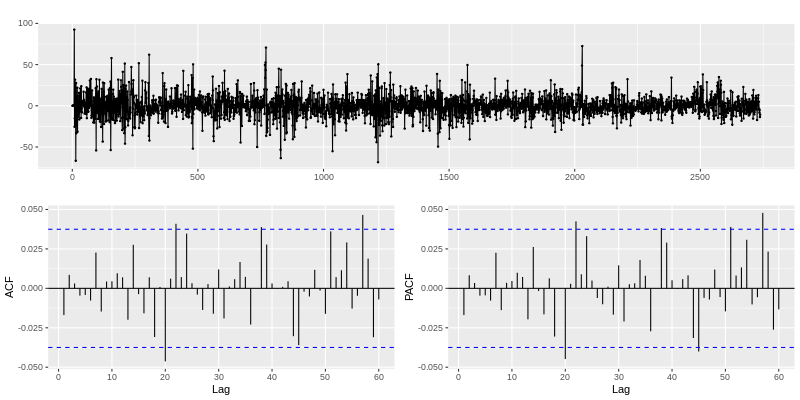

In [ ]:
%%R -w 800 -h 400
ggtsdisplay(mod1_reg$residuals, lag.max= 60)
mod1_reg


In [ ]:
%%R
accuracy(mod1_reg)

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.03022629 14.42906 10.15694 -1.637664 9.500397 0.6687286
                    ACF1
Training set -0.01622313


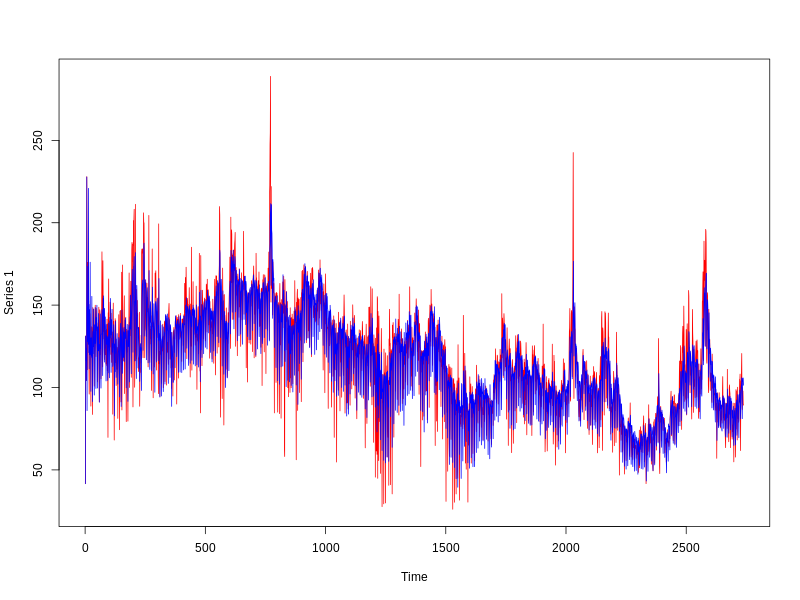

In [ ]:
%%R -w 800 -h 600

plot(xts_ts(train),col="red", series = "Reale")
lines(mod1_reg$fitted,col="blue", series = "Simulata")

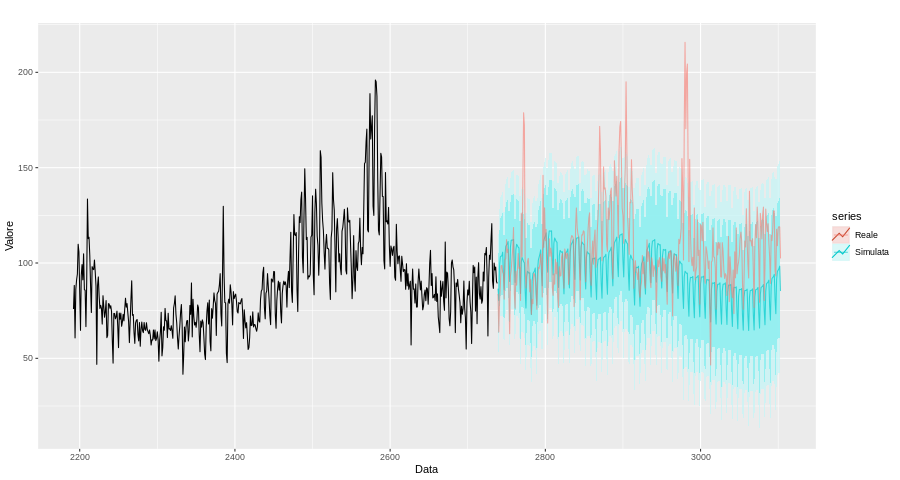

In [45]:
%%R -w 900

previsione2 <- forecast(mod1_reg, h=334, xreg=xreg[(length(train)+1):(length(train)+365),])

autoplot(previsione2)
autoplot(xts_ts(df_ts["2016-01-01/2017-06-30"])) +
autolayer(previsione2,series="Simulata", alpha=0.7) +
autolayer(xts_ts(validation["2017-07-01/2018-06-30"]), series="Reale", alpha=0.6) +
xlab("Data") +
ylab("Valore")

In [ ]:
%%R -w 800 -h 600
score1 <- c(mean(abs(previsione2$mean[1:334] - validation[1:334])/validation[1:334]))
print(paste0("MAPE sul validation: ", score1))

[1] "MAPE sul validation: 0.140218397452561"


Il modello sembra più rappresentativo,  ma si notano ancora i picchi che oltrepassano le bande. Inoltre vediamo che, a seguito dell'introduzione dei regressori sinusoidali, uno dei coeeficienti AR risulta molto vicino ad 1. Proviamo ad aggiungere un'imtegrazione.

In [46]:
%%R -w 800 -h 600
mod_reg_itegr <- Arima(train, c(6,1,12), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], 
              include.constant = TRUE, 
              lambda = "auto")

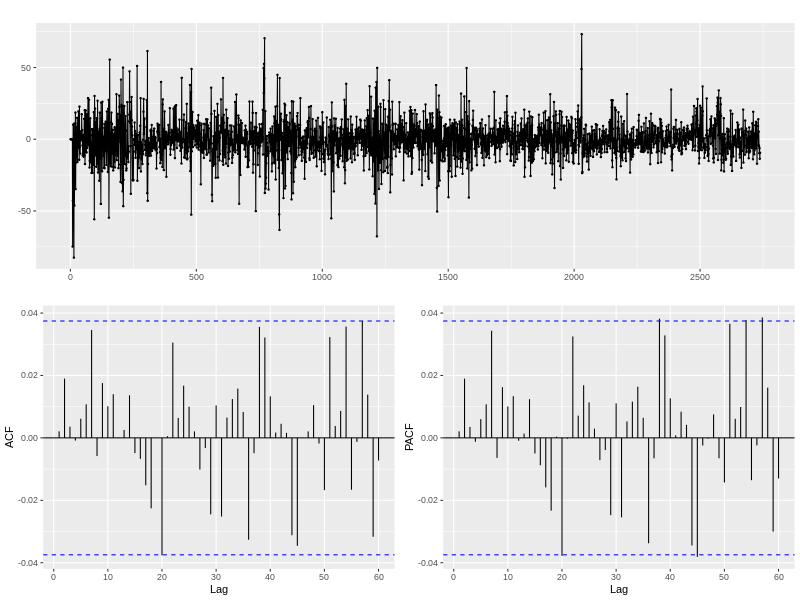

In [ ]:
%%R -w 800 -h 600
ggtsdisplay(mod_reg_itegr$residuals, lag.max = 60)

In [ ]:
%%R
accuracy(mod_reg_itegr)

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.2673822 14.46316 10.18917 -1.781018 9.555768 0.6708504
                    ACF1
Training set 0.003037732


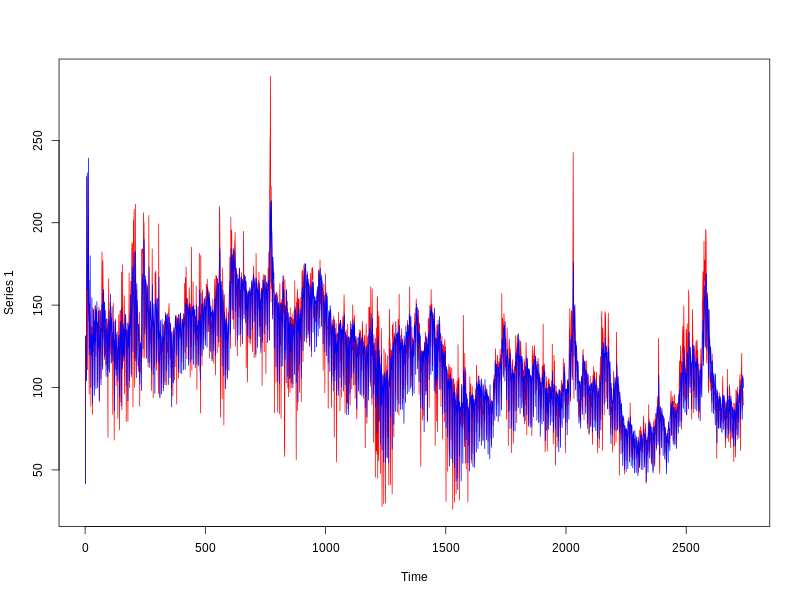

In [ ]:
%%R -w 800 -h 600

plot(xts_ts(train),col="red", series = "Reale")
lines(mod_reg_itegr$fitted,col="blue", series = "Simulata")

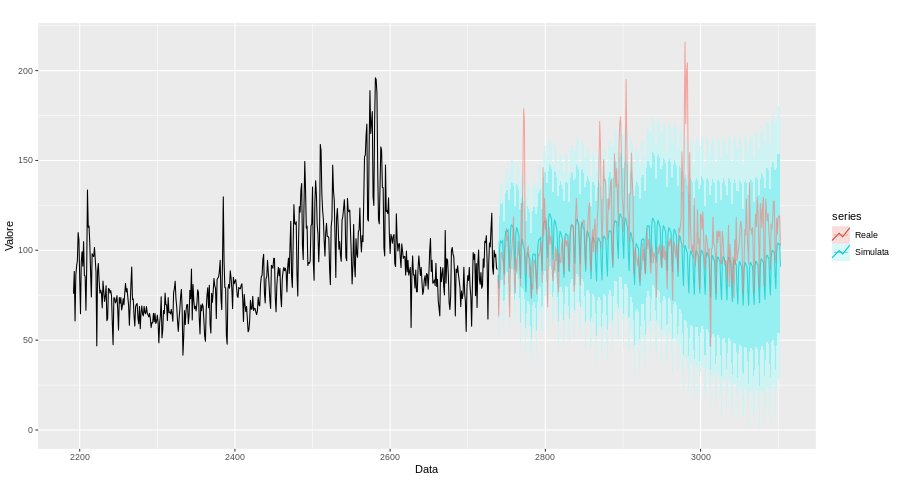

In [47]:
%%R -w 900

previsione3 <- forecast(mod_reg_itegr, h=334, xreg=xreg[(length(train)+1):(length(train)+365),])

autoplot(previsione3)
autoplot(xts_ts(df_ts["2016-01-01/2017-06-30"])) +
autolayer(previsione3,series="Simulata", alpha=0.7) +
autolayer(xts_ts(validation["2017-07-01/2018-06-30"]), series="Reale", alpha=0.6) +
xlab("Data") +
ylab("Valore")

In [ ]:
%%R -w 800 -h 600
score1 <- c(mean(abs(previsione3$mean[1:334] - validation[1:334])/validation[1:334]))
print(paste0("MAPE sul validation: ", score1))

[1] "MAPE sul validation: 0.130075700332611"


Il miglior modello di categoria è risultato essere ARIMA(6,1,12)(1,1,1)[7] con 24 regressori sinusoidali a modellare un'ulteriore stagionalità annuale.

<h1>2) UCM

<h2>Local Linear Trend</h2>

Sviluppiamo un primo modello UCM, inserendo un <b>LLT</b> insieme alle due stagionalità notate in precedenza, quella settimanale e quella annuale.  

In [ ]:
%%time
%%R

modello_ucm_1 <- SSModel(train ~ SSMtrend(2, list(NA,NA)) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig", harmonics = 1:24),
                H = NA)

vary <- var(train, na.rm = TRUE)
modello_ucm_1$P1inf <- modello_ucm_1$P1inf * 0
modello_ucm_1$a1[1] <- mean(train, na.rm = TRUE)
diag(modello_ucm_1$P1) <- vary

#Inizializzione delle varianze
init <- numeric(5)
init[1] <- log(vary/10) 
init[2] <- log(vary/10) 
init[3] <- log(vary/10)
init[4] <- log(vary/10)
init[5] <- log(vary/10) 


#creiamo la funzione di aggiornamento per fitSSM 
funzione_fit_1 <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[4:51, 4:51, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit1 <- fitSSM(modello_ucm_1, init, funzione_fit_1)
print(fit1$optim.out$convergence)

[1] 0
CPU times: user 1min 4s, sys: 27.1 s, total: 1min 32s
Wall time: 46.6 s


Vediamo graficamente l'attinenza del modello ai dati di train:

[1] "MAPE on train 0.109805559360436"


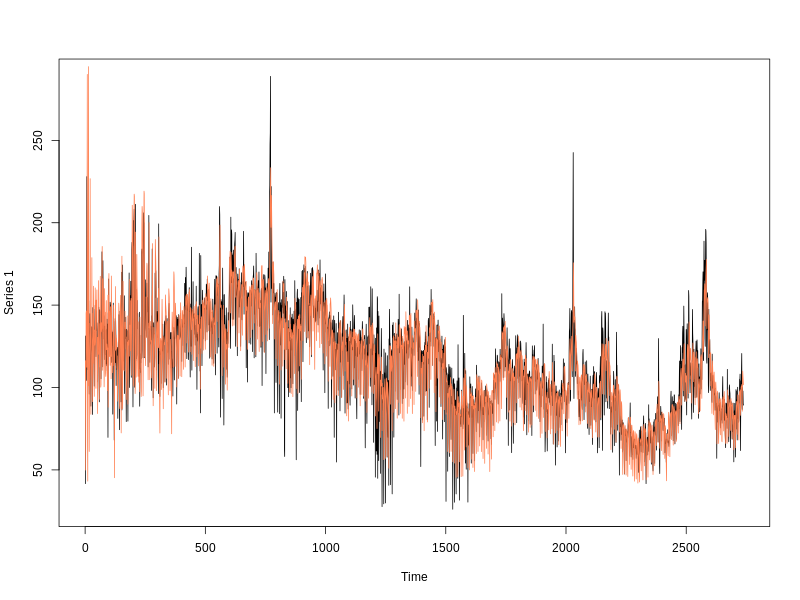

In [ ]:
%%R -w 800 -h 600

ucm_train_1 <- KFS(fit1$model, filtering = "mean", smoothing = NULL)

plot(xts_ts(train))
lines(ucm_train_1$m, col="coral")
print(paste0("MAPE on train ",mean(abs(xts_ts(train) - ucm_train_1$m)/xts_ts(train))))

Vediamo come si comporta il modello appena trovato sui dati di validation.

In [ ]:
%%time
%%R
data <- c(rep(NA, 334))
mod1 <- SSModel(data ~  SSMtrend(2, list(fit1$model$Q[1,1,1],fit1$model$Q[2,2,1])) +
                      SSMseasonal(7, fit1$model$Q[3,3,1], "dummy") +
                      SSMseasonal(365, fit1$model$Q[4, 4, 1], "trig",
                              harmonics = 1:24),
                    H = fit1$model$H)

ucm1_preditction <- predict(fit1$model, newdata=mod1)[1:334]
valid <- validation[1:334]

score <- c(mean(abs(ucm1_preditction - valid)/valid))

print(paste0("UCM MAPE sul validation: ", score))


[1] "UCM MAPE sul validation: 0.147599436527029"
CPU times: user 1.88 s, sys: 839 ms, total: 2.72 s
Wall time: 1.68 s


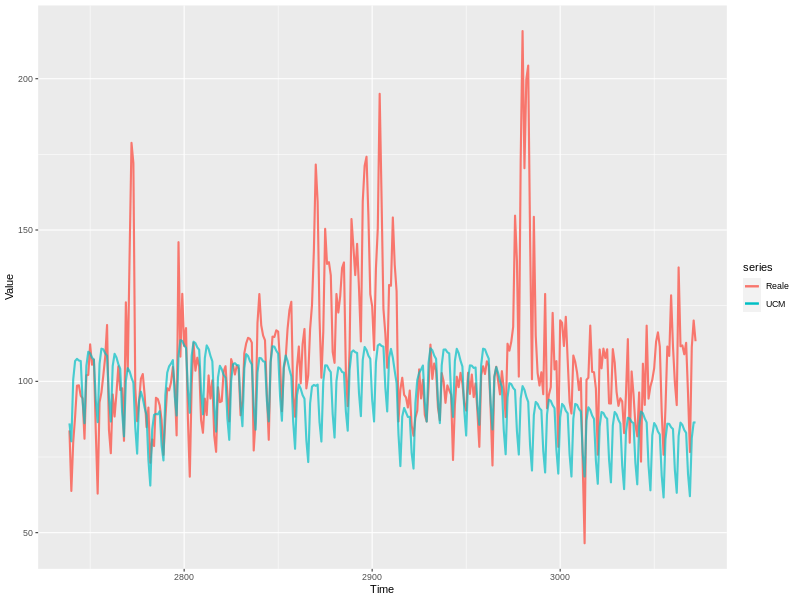

In [ ]:
%%R -w 800 -h 600
ggplot() +
        autolayer(xts_ts(valid), series="Reale",size=1) +
        autolayer(ts(ucm1_preditction, start=start(xts_ts(valid)),
                    frequency=frequency(xts_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value")

<h2>Random Walk</h2>

Proviamo a modificare il modello precedente indagando lutilizzo di un <b>RW</b> al posto del LLT.

In [ ]:
%%time
%%R
modello_ucm_2 <- SSModel(train ~ SSMtrend(1, NA) +
                      SSMseasonal(7, NA, "dummy") +
                      SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                H = NA)

vary <- var(train, na.rm = TRUE)
modello_ucm_2$P1inf <- modello_ucm_2$P1inf * 0
modello_ucm_2$a1[1] <- mean(train, na.rm = TRUE)
diag(modello_ucm_2$P1) <- vary



#valori iniziali delle varianze
init <- numeric(5)
init[1] <- log(vary/10) 
init[2] <- log(vary/10)
init[3] <- log(vary/10)
init[4] <- log(vary/10) 

#funzione per fitSSM
funzione_fit_2 <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    diag(model$Q[3:50, 3:50, 1]) <- exp(pars[3])
    model$H[1, 1, 1] <- exp(pars[4])
    model
}

fit2 <- fitSSM(modello_ucm_2, init, funzione_fit_2)
print(fit2$optim.out$convergence)

[1] 0
CPU times: user 1min 7s, sys: 29.9 s, total: 1min 37s
Wall time: 49.6 s


Vediamo graficamente l'attinenza del modello ai dati di train:

[1] "MAPE on train 0.109360159893767"


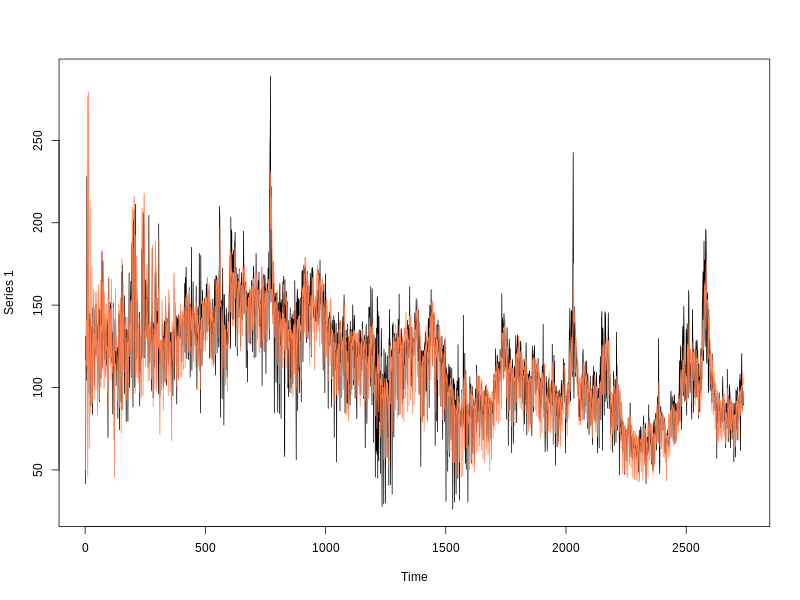

In [ ]:
%%R -w 800 -h 600

ucm_train_2 <- KFS(fit2$model, filtering = "mean", smoothing = NULL)

plot(xts_ts(train))
lines(ucm_train_2$m, col="coral")
print(paste0("MAPE on train ",mean(abs(xts_ts(train) - ucm_train_2$m)/xts_ts(train))))

Vediamo come si comporta questo secondo modello sul validation.

In [ ]:
%%time
%%R

data <- c(rep(NA, 334))
mod2 <- SSModel(data ~  SSMtrend(1, fit2$model$Q[1,1,1]) +
                      SSMseasonal(7, fit2$model$Q[2,2,1], "dummy") +
                      SSMseasonal(365, fit2$model$Q[3, 3, 1], "trig",
                              harmonics = 1:24),
                    H = fit2$model$H)
ucm2_prediction <- predict(fit2$model, newdata=mod2)[1:334]
valid <- validation[1:334]

score <- c(mean(abs(ucm2_prediction - valid)/valid))

print(paste0("UCM 2 MAPE: sul validation", score))

[1] "UCM 2 MAPE: sul validation0.139023401300407"
CPU times: user 1.8 s, sys: 875 ms, total: 2.67 s
Wall time: 1.61 s


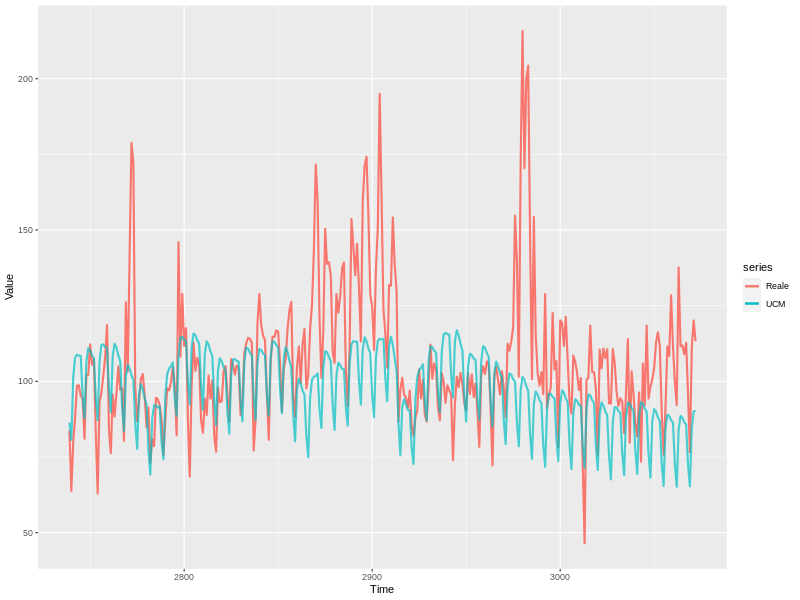

In [ ]:
%%R -w 800 -h 600
ggplot() +
        autolayer(xts_ts(valid), series="Reale",size=1) +
        autolayer(ts(ucm2_prediction, start=start(xts_ts(valid)),
                    frequency=frequency(xts_ts(valid))),
                  series="UCM", size=1, alpha=0.7) +
        xlab("Time") + ylab("Value")

<h1>3) LSTM</h1>

In [55]:
!pip install gpyopt
import GPyOpt

In [56]:
%%capture
!pip install parameter-sherpa

In [57]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import time

%matplotlib inline

In [58]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras        import optimizers, regularizers

from sklearn.preprocessing import StandardScaler

import sherpa #AutoML

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL")

In [59]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [60]:
path = "/content/drive/My Drive/"

In [61]:
df = pd.read_csv("time_series_dataset.csv", sep=";", decimal=".")
df.Data = pd.to_datetime(df.Data)

In [62]:
train = df[df.Data <= pd.to_datetime("2017-06-30")]
val   = df[df.Data  > pd.to_datetime("2017-06-30")]

x_scaler = StandardScaler().\
            fit(np.array(train.value).reshape(-1,1))

train_scaled = x_scaler.transform(np.array(train.value).reshape(-1,1))
val_scaled   = x_scaler.transform(np.array(val.value).reshape(-1,1))

data_scaled = np.concatenate((train_scaled, val_scaled))

In [63]:
def sliding_windows(data, seq_length, pred_lenght):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_lenght-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length:i+seq_length+pred_lenght])

    return np.array(x),np.array(y)

In [64]:
INPUT_SIZE = 730 #due anni
OUTPUT_SIZE = 334

slides = sliding_windows(data_scaled, 
                         INPUT_SIZE ,OUTPUT_SIZE)

X = slides[0].reshape(slides[0].shape[0],
                            slides[0].shape[1],
                           1)
y = slides[1]

X_train, X_val = X[:-216], X[-216:]
y_train, y_val = y[:-216].reshape(-1,y.shape[1]), y[-216:].reshape(-1,y.shape[1])

In [ ]:
def get_model_score(params, epochs=100, verbose=1):
    early = EarlyStopping(monitor='val_loss', patience=50, verbose=0, restore_best_weights = True)

    initial = Input(shape=(INPUT_SIZE,1))

    x = LSTM(int(params['lstm_unit']), activation='tanh', 
           return_sequences=False,
           kernel_regularizer=regularizers.l1(0.001),
           activity_regularizer=regularizers.l1(0.001))(initial)

    x = Dense(int(params["hidden_unit1"]), activation='relu')(x)
    x = Dense(int(params["hidden_unit2"]), activation='relu')(x)

    out = Dense(OUTPUT_SIZE, activation='linear')(x)

    model = Model(initial, out)

    model.compile(loss='mse',
                optimizer=optimizers.RMSprop(learning_rate=params["lr_init"]), 
                metrics=['mae'])

    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            batch_size=int(params["batch_size"]), epochs=epochs, 
            callbacks=[early],
            verbose=verbose)
    
    return model, model.evaluate(X_val, y_val)[0], hist




In [ ]:
parameters = [sherpa.Discrete('lstm_unit',[20,250]),
              sherpa.Discrete('hidden_unit1',[256,512]),
              sherpa.Discrete('hidden_unit2',[256,512]),
              sherpa.Continuous('lr_init', [0.0001, 0.001]),
              sherpa.Ordinal(name='batch_size', range=[64, 128, 256])]
alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=10)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [ ]:
best_score = 999999

for trial in study:
    start_time = time.time()
    
    model, score, hist = get_model_score(trial.parameters)
    
    if np.isnan(score):
        score = 999999
        print("Errore nel modello")
      
    if score != 999999:
        study.add_observation(trial, iteration=1, objective=score)
        if score < best_score:
          try:
            model.save(path + "best_model_1.h5")
          except:
            model.save("best_model_1.h5")
          
          best_model   = model
          best_score   = score
          best_history = hist
    else:
        del model #free RAM
    study.finalize(trial)
    if(trial.id % 10 == 0 or trial.id == 1):
        print("Trial:",trial.id, "|| Best Score: ", best_score, " || Time: ",str(time.time()-start_time), "Seconds")
    study.results.to_csv(path + "AutoML_1.csv")

Epoch 1/100
8/8 [==============================] - 6s 746ms/step - loss: 0.7839 - mae: 0.7018 - val_loss: 0.6725 - val_mae: 0.6011
Epoch 2/100
8/8 [==============================] - 5s 678ms/step - loss: 0.6620 - mae: 0.6229 - val_loss: 0.7716 - val_mae: 0.6391
Epoch 3/100
8/8 [==============================] - 6s 689ms/step - loss: 0.6408 - mae: 0.6118 - val_loss: 0.7950 - val_mae: 0.6446
Epoch 4/100
8/8 [==============================] - 5s 685ms/step - loss: 0.6131 - mae: 0.5934 - val_loss: 0.7536 - val_mae: 0.6247
Epoch 5/100
8/8 [==============================] - 5s 684ms/step - loss: 0.5925 - mae: 0.5739 - val_loss: 0.8855 - val_mae: 0.6871
Epoch 6/100
8/8 [==============================] - 5s 682ms/step - loss: 0.5816 - mae: 0.5641 - val_loss: 0.8588 - val_mae: 0.6756
Epoch 7/100
8/8 [==============================] - 5s 681ms/step - loss: 0.5759 - mae: 0.5614 - val_loss: 0.8512 - val_mae: 0.6721
Epoch 8/100
8/8 [==============================] - 6s 689ms/step - loss: 0.5707 - m

KeyboardInterrupt: ignored

In [65]:
best_model_1 = tf.keras.models.load_model(path + "best_model_1.h5")

In [13]:
best_model_1.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 730, 1)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 110)               49280     
_________________________________________________________________
dense_12 (Dense)             (None, 452)               50172     
_________________________________________________________________
dense_13 (Dense)             (None, 302)               136806    
_________________________________________________________________
dense_14 (Dense)             (None, 334)               101202    
Total params: 337,460
Trainable params: 337,460
Non-trainable params: 0
_________________________________________________________________


In [24]:
pred_train = best_model_1.predict(X_train)
valid_train= x_scaler.inverse_transform(y_train).reshape(y_train.shape[0],y_train.shape[1])
pred_train = x_scaler.inverse_transform(pred_train)

print("MAPE sul train:",np.mean(list(map(np.mean,np.abs(pred_train - valid_train)/np.abs(valid_train)))))

MAPE sul train: 0.2737693360071065


In [23]:
pred = best_model_1.predict(X_val)
valid = x_scaler.inverse_transform(y_val).reshape(y_val.shape[0],y_val.shape[1])
pred = x_scaler.inverse_transform(pred)

print("MAPE sul validation:",np.mean(list(map(np.mean,np.abs(pred - valid)/np.abs(valid)))))

MAPE sul validation: 0.1683500760406877


In [21]:
best_model_1.evaluate(X_train, y_train)
best_model_1.evaluate(X_val, y_val)

7/7 [==============================] - 1s 109ms/step - loss: 0.6108 - mean_absolute_error: 0.5941


[0.6108375191688538, 0.5941322445869446]

<br />
<hr />

<h1><b>FORECASTING</b></h1>

<h3>Modello ARIMA</h3>

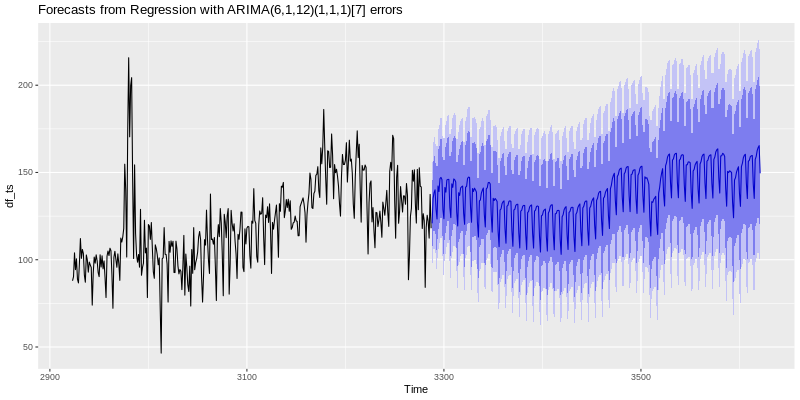

CPU times: user 22min 40s, sys: 16min 29s, total: 39min 9s
Wall time: 19min 55s


In [66]:
%%time
%%R -w 800 -h 400

freq <- outer(1:(length(df_ts)+365), 1:24)*2*pi/365

cs   <- cos(freq)                   
colnames(cs) <- paste("cos", 1:24)
si   <- sin(freq)                   
colnames(si) <- paste("sin", 1:24)

more_reg <- as.matrix(cbind(cs,si))

xreg <- more_reg 

mod_final_reg <- Arima(df_ts, c(6,1,12), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:length(df_ts),], include.constant = TRUE, lambda = "auto")


arima_test <- forecast(mod_final_reg, h=334, xreg=xreg[(length(df_ts)+1):(length(df_ts)+334),])
arima_test_mean <- arima_test$mean

autoplot(arima_test, include=365)

<h3>Modello UCM</h3>

In [67]:
%%time
%%R
extra <- data.frame(Data=seq(as.Date("2019-01-01"), as.Date("2019-11-30"), by="day"), value=NA)
new_df <- rbind(df,extra)
ytrain <- xts(new_df$value, order.by=new_df$Data)

ucm_mod_final <- SSModel(ytrain ~ SSMtrend(1, NA) +
                          SSMseasonal(7, NA, "dummy") +
                          SSMseasonal(365, NA, "trig",
                                  harmonics = 1:24),
                         H = NA)

vary <- var(ytrain, na.rm = TRUE)
ucm_mod_final$P1inf <- ucm_mod_final$P1inf * 0
ucm_mod_final$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(ucm_mod_final$P1) <- vary



#valore iniziale delle varianze
init <- numeric(5)
init[1] <- 0 
init[2] <- log(vary/10)
init[3] <- log(vary/10)
init[4] <- log(vary/10)
init[5] <- log(vary/10)

# Estimate
up_fit <- function(pars, model){
    model$Q[1, 1, 1] <- exp(pars[1])
    model$Q[2, 2, 1] <- exp(pars[2])
    model$Q[3, 3, 1] <- exp(pars[3])
    diag(model$Q[3:50, 3:50, 1]) <- exp(pars[4])
    model$H[1, 1, 1] <- exp(pars[5])
    model
}

fit_final <- fitSSM(ucm_mod_final, init, up_fit)
print(fit_final$optim.out$convergence)

smo_final <- KFS(fit_final$model, filtering="mean",smoothing="none")
ucm_test_mean <- smo_final$m[(length(ytrain)-334+1):length(ytrain)]


[1] 0
CPU times: user 1min 3s, sys: 29.1 s, total: 1min 32s
Wall time: 47.5 s


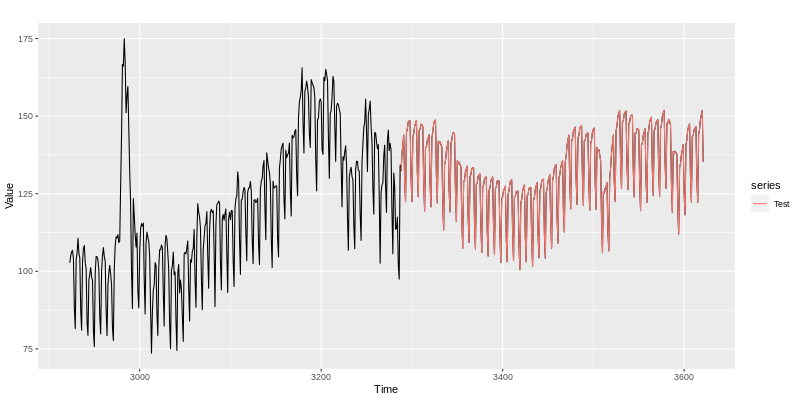

In [68]:
%%R -w 800 -h 400
plot_ucm <- xts(as.numeric(smo_final$m), order.by=new_df$Data)
autoplot(xts_ts(plot_ucm["2018-01-01/2019-11-30"]))+
    autolayer(xts_ts(plot_ucm["2019-01-01/2019-11-30"]), series="Test") +
    ylab("Value")

<h3>Modello LSTM</h3>

In [69]:
best_model = tf.keras.models.load_model(path + "best_model_1.h5")
best_model.fit(X_val,y_val,epochs=100, verbose=1)

Epoch 1/100
7/7 [==============================] - 3s 423ms/step - loss: 0.6098 - mean_absolute_error: 0.5934
Epoch 2/100
7/7 [==============================] - 3s 427ms/step - loss: 0.6075 - mean_absolute_error: 0.5915
Epoch 3/100
7/7 [==============================] - 3s 426ms/step - loss: 0.6049 - mean_absolute_error: 0.5894
Epoch 4/100
7/7 [==============================] - 3s 425ms/step - loss: 0.6021 - mean_absolute_error: 0.5870
Epoch 5/100
7/7 [==============================] - 3s 423ms/step - loss: 0.5990 - mean_absolute_error: 0.5841
Epoch 6/100
7/7 [==============================] - 3s 416ms/step - loss: 0.5956 - mean_absolute_error: 0.5809
Epoch 7/100
7/7 [==============================] - 3s 427ms/step - loss: 0.5918 - mean_absolute_error: 0.5770
Epoch 8/100
7/7 [==============================] - 3s 421ms/step - loss: 0.5877 - mean_absolute_error: 0.5727
Epoch 9/100
7/7 [==============================] - 3s 415ms/step - loss: 0.5834 - mean_absolute_error: 0.5683
Epoch 10/1

In [70]:
%%R
test <- df_ts["2017-01-01/"]

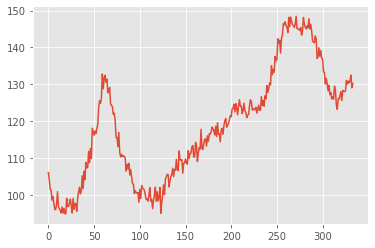

In [71]:
%R -o test -w 800 -h 400
X_test = x_scaler.transform(np.array(test)).reshape(1,-1,1)
lstm_test = x_scaler.inverse_transform(best_model.predict(X_test)[0])

plt.plot(lstm_test)
plt.show()

<h1><b>MODELLI A CONFRONTO</b></h1>

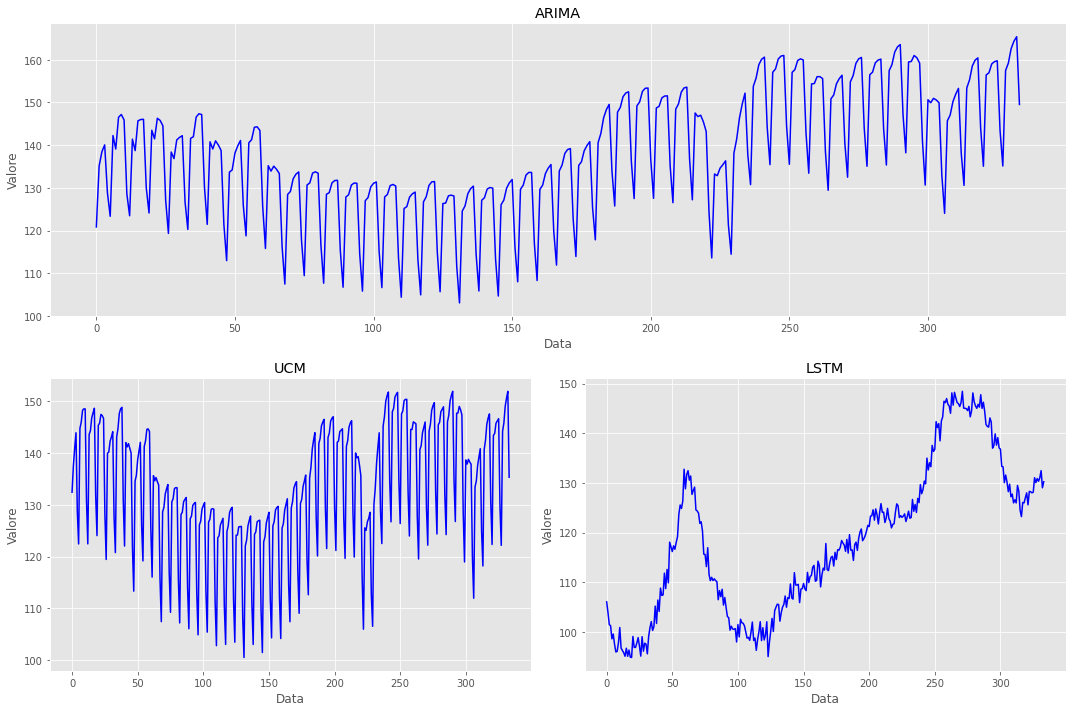

In [72]:
%R -o ucm_test_mean -o arima_test_mean

fig = plt.figure(figsize=(15, 10))

ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(np.array(arima_test_mean), color="blue")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.title("ARIMA")

ax1 = plt.subplot2grid((2, 2), (1, 0))

plt.plot(np.array(ucm_test_mean), color="blue")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.title("UCM")

ax2 = plt.subplot2grid((2, 2), (1, 1))

plt.plot(np.array(lstm_test), color="blue")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.title("LSTM")

plt.tight_layout()
plt.savefig(path + 'test_results.png')

<h4>Creazione del file dei risultati:</h4>

In [73]:
submission = pd.DataFrame({'Data' :pd.date_range('2019-01-01', periods=334, freq='D'),
                           'ARIMA':arima_test_mean,
                           'UCM'  :ucm_test_mean,
                           'ML'   :lstm_test})

In [74]:
submission.to_csv(path + 'SDMTSA_839141_1.csv', index=None)